In [3]:
import os, pickle, warnings
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np

# modeling/experimentation
import mlflow
import skgstat as skg
import gstools as gs
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pykrige.compat import Krige

# to load parameters of the experiments
from kedro.config import ConfigLoader

# utils
from joblib import Parallel, delayed
from pandas import IndexSlice as idx
from IPython.display import display

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# experiments
from experiments.noaa import NOAAKrigingExperiment

# local utils and other imports
from spatial_interpolation import data, utils
from spatial_interpolation.utils.experiments import conf 
from spatial_interpolation.data.load_data import get_ml_workspace
from spatial_interpolation.utils import tqdm_joblib
from spatial_interpolation.visualization import plot_interpolation
from experiments.configs.evaluation import eval_sets as eval_conf

# notebook configuration
import dotenv
warnings.simplefilter(action='ignore', category=FutureWarning)
dotenv.load_dotenv()

True

In [85]:
# load data
experiment = NOAAKrigingExperiment("ok_linear", n_jobs=20)
config = experiment.get_config()
dataset = data.NDBCDataLoader(**config.data_loading).load()
df, gdf = dataset.buoys_data, dataset.buoys_geo
area = eval_conf.ndbc[config.eval_set].area
locations_within_area = gdf.loc[gdf.within(area)].index.get_level_values("buoy_id").unique()
df = df.loc[df.index.get_level_values("buoy_id").isin(locations_within_area)]
gdf = gdf.loc[idx[:, locations_within_area],:]
dataset = data.NDBCData(df, gdf)
df_countries = data.load_world_borders(boundaries=area)

train, test = dataset.split_slice(test=eval_conf.ndbc[config.eval_set].eval)
train_df = train.join()
test_df = test.join()

target = config.target
train_by_times = (
    train_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
)
test_by_times = (
    test_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(80437, 14)]


In [50]:
experiment = NOAAKrigingExperiment("ok_linear", n_jobs=20)
config = experiment.get_config()
config.krige(krige_params=config.krige_params.to_dict())

pyKrige(method=ordinary, n_closest_points=5, variogram_model=gaussian)

In [9]:
time = "2020-05-10 05:00" #train_by_times.index.get_level_values(0)[-1]
krige = Krige(method='ordinary', variogram_model='gaussian')
dims = config.dimensions
krige.fit(train_by_times.loc[time,dims].values,y=train_by_times.loc[time,target].values)

In [ ]:
krige.predict(test_by_times.loc[time,dims].values)

Linear(latlon=True, var=0.142, len_scale=6.52e+02, nugget=3.74e-15, rescale=6.37e+03)


<Figure size 432x288 with 0 Axes>

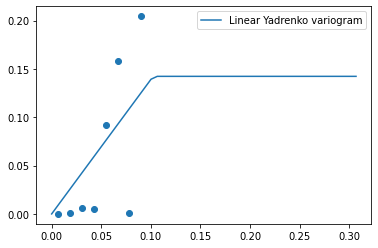

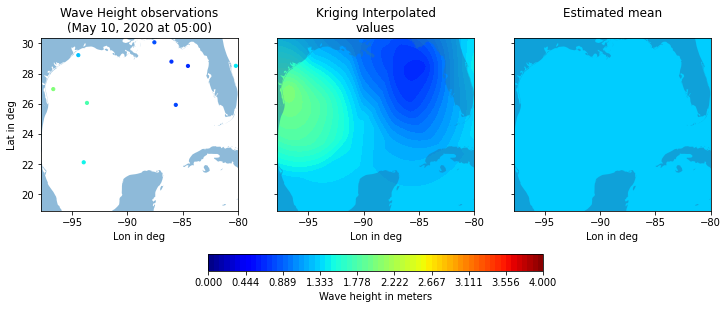

In [117]:
plt.set_cmap('jet')
x = train_by_times.loc[time,dims]
lat, lon = x.values[:,1],x.values[:,0]
y = train_by_times.loc[time,target]
bins = gs.standard_bins((lon,lat),latlon=True)
bin_c, vario = gs.vario_estimate((x.values[:,1],x.values[:,0]),train_by_times.loc[time,target].values,latlon=True)
model = gs.Linear(latlon=True, rescale=gs.EARTH_RADIUS)
model.fit_variogram(bin_c, vario)
ax = model.plot("vario_yadrenko")#, x_max=bins[-1])
ax.scatter(bin_c, vario)
print(model)
uk = gs.krige.Ordinary(
    model=model,
    cond_pos=(x.values[:,1],x.values[:,0]),
    cond_val=train_by_times.loc[time,target].values,
    # drift_functions=north_south_drift,
)
xmin, ymin, xmax, ymax = area.bounds
grid_lats, grid_lons = np.linspace(ymin, ymax, 100), np.linspace(xmin, xmax, 100)
uk.set_pos((grid_lats, grid_lons), mesh_type="structured")
uk(return_var=False, store="field")
uk(only_mean=True, store="mean_field")

levels = np.linspace(0, 4, 64)
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
sca = ax[0].scatter(lon, lat, c=y, vmin=0, vmax=4, s=10)
co1 = ax[1].contourf(grid_lons, grid_lats, uk["field"], levels)
co2 = ax[2].contourf(grid_lons, grid_lats, uk["mean_field"], levels)

[df_countries.plot(ax=ax[i],alpha=0.5) for i in range(3)]
[ax[i].set_xlim([xmin, xmax]) for i in range(3)]
[ax[i].set_ylim([ymin, ymax]) for i in range(3)]
[ax[i].set_xlabel("Lon in deg") for i in range(3)]
ax[0].set_ylabel("Lat in deg")

ax[0].set_title(f"Wave Height observations\n({pd.Timestamp(time):%b %d, %Y at %H:%M})")
ax[1].set_title("Kriging Interpolated\nvalues")
ax[2].set_title("Estimated mean\n")

fmt = dict(orientation="horizontal", shrink=0.5, fraction=0.1, pad=0.1)
fig.colorbar(co2, ax=ax, **fmt).set_label("Wave height in meters")
# fig.tight_layout()

In [46]:
pred, ss = krige.model.execute(
    "points", 
    test_by_times.loc[time,dims].values[:,0],test_by_times.loc[time,dims].values[:,1]
)
pd.DataFrame({target:pred},index=test_by_times.loc[time].index)\
    .join(test_by_times[target],rsuffix="_true")\
        .rename(columns={target:"y_pred", f"{target}_true":"y_true"})

y_pred  y_true
time                location_id                  
2020-05-10 05:00:00 42019        1.697355    2.17
                    42040        0.870666    1.05

In [77]:
V = skg.Variogram(train_by_times.loc[time,dims], train_by_times.loc[time,target])
# V.model = "gaussian"
print("Variogram fitted:",V.model.__name__)
kr = V.to_gs_krige()
kr.set_pos((test_by_times.loc[time,dims].values[:,0],test_by_times.loc[time,dims].values[:,1]),mesh_type="unstructured")
kr(return_var=False, store="field")
kr(only_mean=True, store="mean_field")
pred= kr["field"]
pd.DataFrame({target:pred},index=test_by_times.loc[time].index)\
    .join(test_by_times[target],rsuffix="_true")\
        .rename(columns={target:"y_pred", f"{target}_true":"y_true"})

Variogram fitted: spherical


y_pred  y_true
time                location_id                  
2020-05-10 05:00:00 42019        1.677907    2.17
                    42040        0.843030    1.05

In [76]:
from skgstat import OrdinaryKriging

ok = OrdinaryKriging(V, min_points=5, max_points=20, mode='exact')
ok.transform(test_by_times.loc[time,dims].values)

array([1.69139376, 0.8791894 ])